# Image Areafilter / De-Areafilter Demo

This notebook demonstrates how to area filter (box filter) original image and then attempt to reconstruct the original image.

## 1. Load Original Image

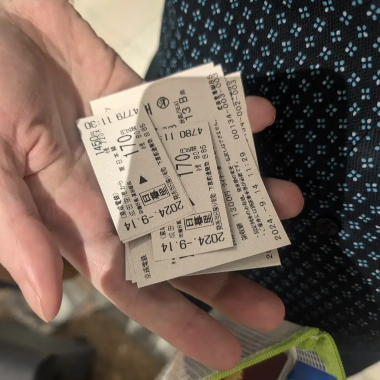

In [17]:
import PIL.Image as Image
import torchvision.transforms.functional as TF

frame_original = TF.to_tensor(Image.open('template.png').convert('RGBA')).unsqueeze_(0)

H, W = frame_original.size()[-2:]

TF.to_pil_image(frame_original[0])

## 2. Filter the Image

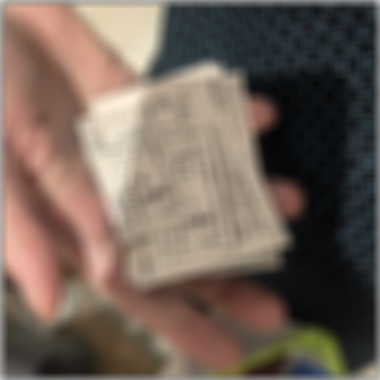

In [18]:
import torch
import torch.nn.functional as F

CHUNK_SIZE = 16

frame_filtered = F.avg_pool2d(
    F.pad(frame_original, (CHUNK_SIZE, CHUNK_SIZE, CHUNK_SIZE, CHUNK_SIZE)),
    CHUNK_SIZE, 1
)[..., CHUNK_SIZE//2:, CHUNK_SIZE//2:][...,:H, :W]

# quantize to 8bit
frame_filtered = frame_filtered.mul(0xFF).to(torch.uint8).float().div(0xFF)

TF.to_pil_image(frame_filtered[0])

## 3. Restore the Original Image with Gradient-Decent

just gradient descent the `trained` (`filtered` as basis) to output `filtered` after a a `avg_pool2d` (~ `area` filter).

deconvolution .. since we know the PSF.\
https://en.wikipedia.org/wiki/Deconvolution

this of course, only works in the ideal case.




use device xpu


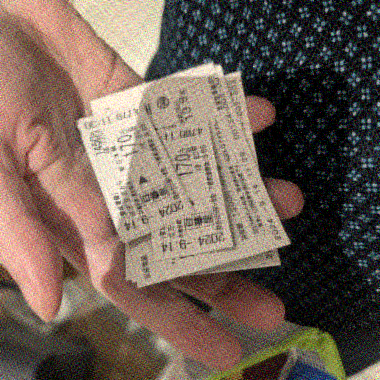

0.00% loss 0.01595151051878929
10.00% loss 0.0006674770265817642
20.00% loss 0.0005690438556484878
30.00% loss 0.0005263551720418036
40.00% loss 0.0005011457251384854
50.00% loss 0.00048369652358815074
60.00% loss 0.0004703862650785595
70.00% loss 0.00045986470649950206
80.00% loss 0.00045076292008161545
90.00% loss 0.00044295069528743625
100.00% loss 0.00043602343066595495


In [4]:
import torch.nn as nn
import torch.optim as optim

device = 'cpu'
if torch.xpu.is_available():
    device = 'xpu'
elif torch.cuda.is_available():
    device = 'cuda'
print('use device', device)

frame_accumulated = frame_filtered.to(device).detach()
frame_trained = nn.Parameter(frame_accumulated.clone(), requires_grad=True)

u = display(TF.to_pil_image(frame_trained[0]), display_id=True)

optimizer = optim.Adamax([frame_trained])
ROUNDS = 5000
for i in range(ROUNDS):
    filtered = F.avg_pool2d(
        F.pad(frame_trained, (CHUNK_SIZE, CHUNK_SIZE, CHUNK_SIZE, CHUNK_SIZE)),
        CHUNK_SIZE, 1
    )[..., CHUNK_SIZE//2:, CHUNK_SIZE//2:][...,:H, :W]
    optimizer.zero_grad()
    loss = F.l1_loss(filtered, frame_accumulated)
    loss.backward()
    optimizer.step()
    loss = loss.detach()

    frame_trained.data.clamp_(0, 1)
    if (i % 100) == 0:
        u.update(TF.to_pil_image(frame_trained.data[0]))

    if (i % (ROUNDS // 10)) == 0:
        print(f'{i / ROUNDS * 100:03.2f}%', 'loss', float(loss))
print(f'{100:03.2f}%', 'loss', float(loss))

u.update(TF.to_pil_image(frame_trained.data[0]))